## Goal
**Which variables are significant in predicting the demand for shared bikes.**

**How well those variables describe the bike demands**

Data dictionary: [here](https://cdn.upgrad.com/uploads/production/0fdfa494-a9bf-4b32-873f-900e3b262948/Readme.txt)

In [1015]:

import csv, matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
# r2_score(y_test, y_pred)

## EDA

In [1016]:
bikes = pd.read_csv("https://docs.google.com/uc?export=download&id=1GURdrVzW6YqQt9R3I6X37m9pb73B5Kl0",encoding = 'unicode_escape')
bikes

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [1017]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [1018]:
## checking NAs
round(100*bikes.isna().sum()/len(bikes.index),2)

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

In [1019]:
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [1020]:
len(bikes.instant.unique())

730

In [1021]:
# instant is not a business specific variable but just a primary key, hence removing it
bikes.set_index('instant', inplace=True)

Dropping casual and registered columns since they are daily aggregate metrics (division of total count) and are not useful/available for the demand prediction day.

In [1022]:
bikes.drop(["casual","registered"],inplace=True,axis=1)

In [1023]:
## convert timestamp to relevant format
## drop month and day information since month , year already columns, this will reduce VIF for this predictor as well
## Derived variable
bikes["day"] = pd.to_datetime(bikes.dteday).dt.day.apply(lambda x: "{:02d}".format(x))
bikes.day

instant
1      01
2      01
3      01
4      01
5      01
       ..
726    27
727    28
728    29
729    30
730    31
Name: day, Length: 730, dtype: object

In [1024]:
bikes.drop(["dteday"],inplace=True,axis=1)

In [1025]:
## relabelling categorical variables using the provided daata dictionary  ###
bikes.season = bikes.season.map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})
bikes.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [1026]:
## converting to categorical and not to timestamp type since we have only 2 year data
bikes.yr = bikes.yr.map({0:"2018",1:"2019"})
bikes.yr.value_counts()

2018    365
2019    365
Name: yr, dtype: int64

In [1027]:
# pad leading zeros, useful in graphs 
bikes.mnth = bikes.mnth.apply(lambda x: "{:02d}".format(x))
bikes.mnth.value_counts()

12    62
07    62
03    62
01    62
10    62
08    62
05    62
09    60
11    60
04    60
06    60
02    56
Name: mnth, dtype: int64

In [1028]:
bikes.holiday = bikes.holiday.map({0:"no",1:"yes"})
bikes.holiday.value_counts()

no     709
yes     21
Name: holiday, dtype: int64

In [1029]:
bikes.weekday = bikes.weekday.apply(lambda x: str(x))
bikes.weekday.value_counts()

1    105
0    105
6    105
5    104
4    104
2    104
3    103
Name: weekday, dtype: int64

In [1030]:
bikes.workingday = bikes.workingday.map({0:"no",1:"yes"})
bikes.workingday.value_counts()

yes    499
no     231
Name: workingday, dtype: int64

In [1031]:
bikes.weathersit = bikes.weathersit.map({1:"clear",2:"cloudy",3:"rainy",4:"thunderstorm"})
bikes.weathersit.value_counts()

clear     463
cloudy    246
rainy      21
Name: weathersit, dtype: int64

In [1032]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    object 
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    object 
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    object 
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
 12  day         730 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 79.8+ KB


**Analysing correlations: Continous variables**

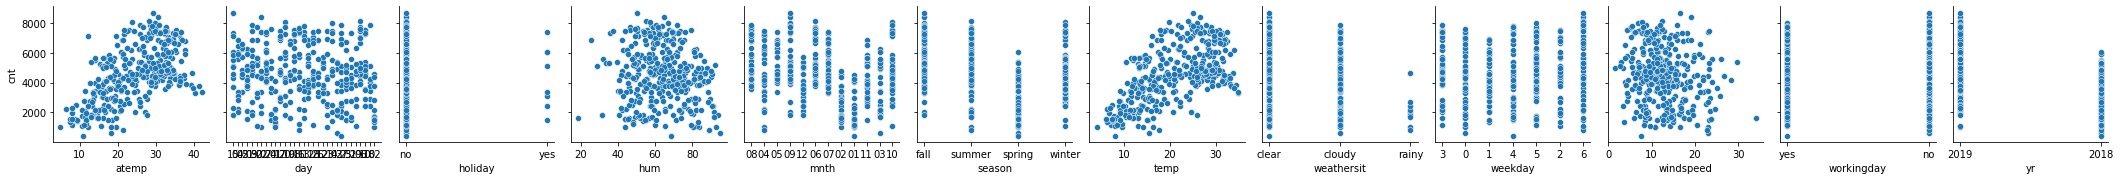

In [1033]:
## briefly analysing here by downsampling, before test split and one hot encoding 
## considering continuous variables before labelling for visualisation, 
bikes_s = bikes.sample(frac = 0.5, replace = False, random_state = 123)
g = sns.pairplot(data = bikes_s,y_vars=['cnt'], x_vars = bikes_s.columns.difference(["cnt"]))
# g.fig
plt.show()

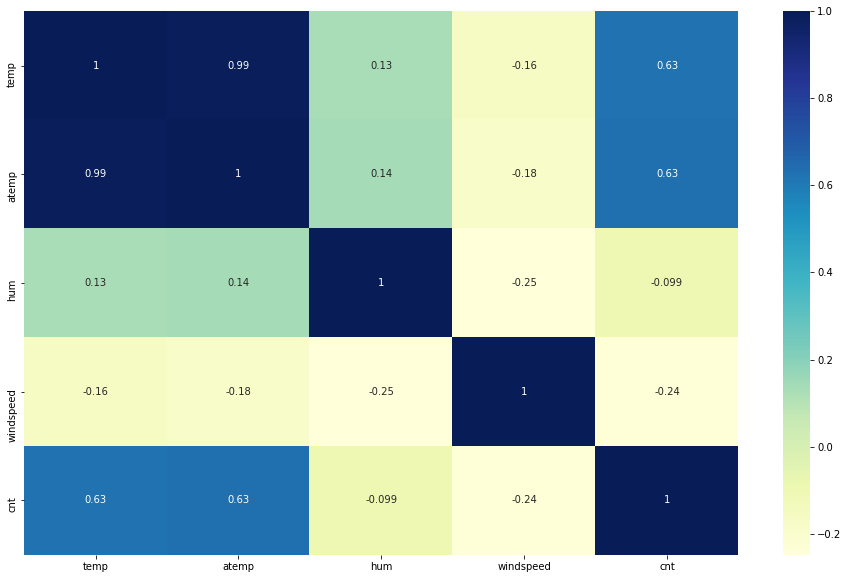

In [1034]:
plt.figure(figsize = (16, 10))
sns.heatmap(bikes.corr(), annot = True, cmap="YlGnBu")
plt.show()

**Temperature seem to impact bike demand**


**Analysing categorical variables**

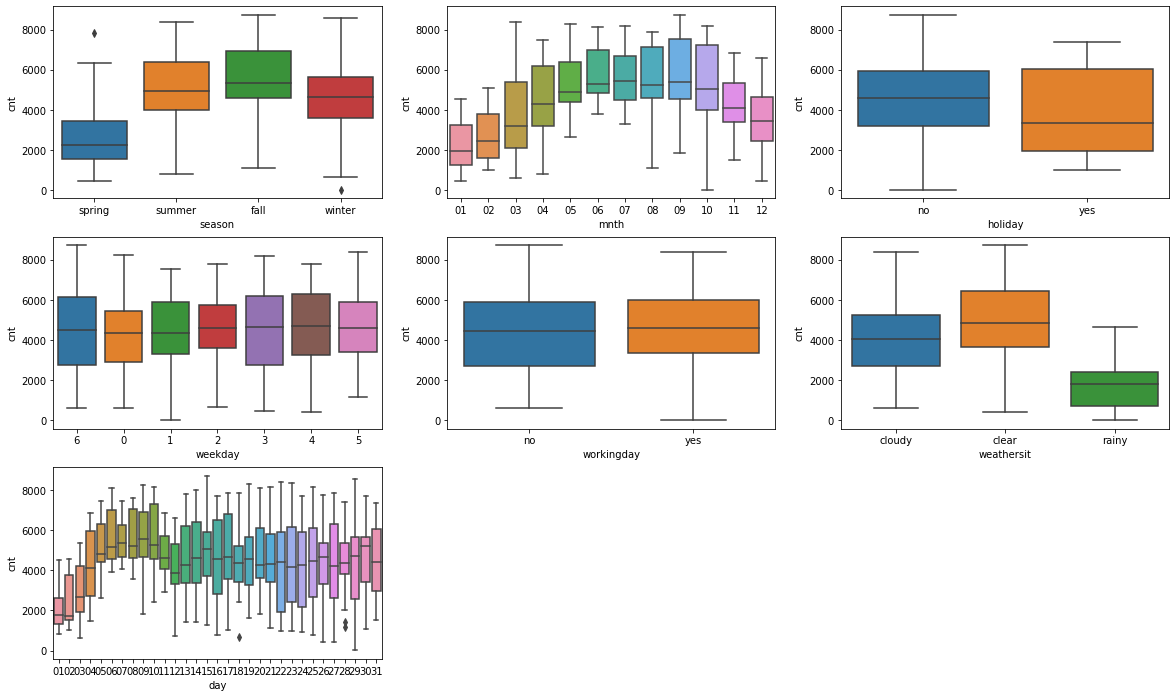

In [1035]:
# bikes.select_dtypes("object").columns
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bikes)
plt.subplot(3,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bikes)
plt.subplot(3,3,3)
sns.boxplot(x = 'holiday', y = 'cnt', data = bikes)
plt.subplot(3,3,4)
sns.boxplot(x = 'weekday', y = 'cnt', data = bikes)
plt.subplot(3,3,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = bikes)
plt.subplot(3,3,6)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bikes)
plt.subplot(3,3,7)
sns.boxplot(x = 'day', y = 'cnt', data = bikes, order= sorted(bikes.day.value_counts().index.to_list()))
plt.show()

In [1036]:
# dropping day as doesn't seem informative
bikes.drop(["day"],inplace=True,axis=1)

**We observe that Season, month, holiday and weather impact bike demands**

**Creating dummy variables**

In [1037]:
## keeping n-1 levels for min predictors and hence better adjusted r-squared
bikes = pd.get_dummies( bikes , columns=bikes.select_dtypes("object").columns, drop_first = True) 
bikes

,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_02,mnth_03,mnth_04,mnth_05,mnth_06,mnth_07,mnth_08,mnth_09,mnth_10,mnth_11,mnth_12,holiday_yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_yes,weathersit_cloudy,weathersit_rainy
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,10.420847,11.33210,65.2917,23.458911,2114,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0
727,10.386653,12.75230,59.0000,10.416557,3095,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
728,10.386653,12.12000,75.2917,8.333661,1341,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


**Splitting the Data into 80/20 Training and Testing Sets**


In [1038]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(bikes, train_size = 0.8, test_size = 0.2, random_state = 100)
df_train


,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_02,mnth_03,mnth_04,mnth_05,mnth_06,mnth_07,mnth_08,mnth_09,mnth_10,mnth_11,mnth_12,holiday_yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_yes,weathersit_cloudy,weathersit_rainy
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
368,6.150000,6.31375,44.1250,24.499957,2236,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
649,17.835000,21.55835,46.3333,12.166932,7570,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
45,17.015000,19.91750,37.5833,27.999836,1913,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
706,13.154153,16.09790,76.4167,8.750200,5008,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
380,6.833347,8.08125,41.9167,16.834286,2311,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,30.852500,35.35440,65.9583,8.666718,7261,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
54,9.091299,12.28585,42.3043,6.305571,1917,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
351,10.591653,12.46855,56.0833,16.292189,2739,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


In [1039]:
# bikes.drop(bikes.select_dtypes("object").columns, inplace=True)
# bikes = pd.concat([bikes, one_hot], axis = 1)

**Rescaling data**

In [1040]:
## using min-max instead of standard scalar as it has better interpretability.
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()

In [1041]:
num_vars = bikes.select_dtypes(["float64","int64"]).columns  ## not scaling timestamp
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_02,mnth_03,mnth_04,mnth_05,mnth_06,mnth_07,mnth_08,mnth_09,mnth_10,mnth_11,mnth_12,holiday_yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_yes,weathersit_cloudy,weathersit_rainy
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
368,0.113228,0.061963,0.454701,0.695175,0.254717,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
649,0.468352,0.462175,0.477458,0.299450,0.868385,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
45,0.443431,0.419099,0.387290,0.807474,0.217556,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
706,0.326094,0.318824,0.787463,0.189819,0.573631,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
380,0.133996,0.108365,0.431945,0.449210,0.263346,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,0.863973,0.824359,0.679690,0.187140,0.832835,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
54,0.202618,0.218747,0.435939,0.111379,0.218017,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
351,0.248216,0.223544,0.577930,0.431816,0.312586,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0


**Analysing correlations just before modolling**

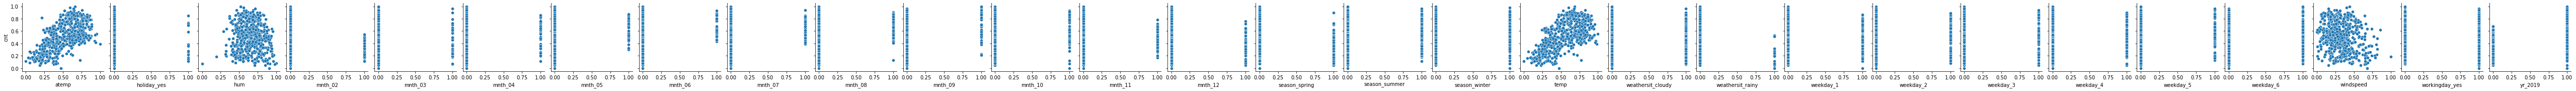

In [1042]:
sns.pairplot(df_train,y_vars=['cnt'], x_vars = df_train.columns.difference(["cnt"]))
plt.show()

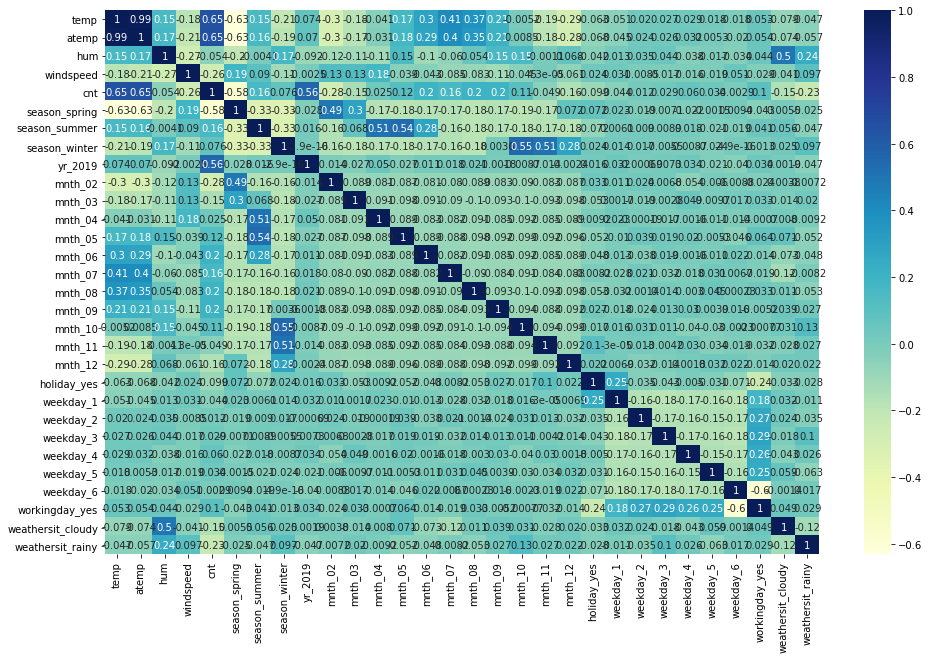

In [1043]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Modelling


In [1044]:
y_train = df_train.pop('cnt')
X_train = df_train

Lets start with a model by considering all features

In [1045]:
X_train_all = sm.add_constant(X_train)
lm_all = sm.OLS(y_train,X_train_all).fit() 
print(lm_all.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     120.3
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          3.26e-215
Time:                        15:14:34   Log-Likelihood:                 613.26
No. Observations:                 584   AIC:                            -1169.
Df Residuals:                     555   BIC:                            -1042.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2187      0.04

A lot of variables eg: atemp, weekdays and month are insignificant. Lets proceed with the previous rfe model and check VIF for temp/atemp.

In [1046]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [1047]:
# Use RFE to find top 10 features
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15, verbose=0)             
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', False, 2),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('yr_2019', True, 1),
 ('mnth_02', False, 7),
 ('mnth_03', False, 3),
 ('mnth_04', False, 6),
 ('mnth_05', False, 4),
 ('mnth_06', False, 5),
 ('mnth_07', False, 8),
 ('mnth_08', True, 1),
 ('mnth_09', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 12),
 ('mnth_12', False, 13),
 ('holiday_yes', True, 1),
 ('weekday_1', False, 9),
 ('weekday_2', False, 10),
 ('weekday_3', False, 14),
 ('weekday_4', False, 15),
 ('weekday_5', False, 11),
 ('weekday_6', True, 1),
 ('workingday_yes', True, 1),
 ('weathersit_cloudy', True, 1),
 ('weathersit_rainy', True, 1)]

In [1048]:
col = X_train.columns[rfe.support_]
col


Index(['temp', 'atemp', 'hum', 'windspeed', 'season_summer', 'season_winter',
       'yr_2019', 'mnth_08', 'mnth_09', 'mnth_10', 'holiday_yes', 'weekday_6',
       'workingday_yes', 'weathersit_cloudy', 'weathersit_rainy'],
      dtype='object')

In [1049]:
X_train.columns[~rfe.support_]

Index(['season_spring', 'mnth_02', 'mnth_03', 'mnth_04', 'mnth_05', 'mnth_06',
       'mnth_07', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5'],
      dtype='object')

Building model using statsmodel, for the detailed statistics


In [1050]:
X_train_rfe = X_train[col]
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     220.0
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          4.28e-225
Time:                        15:14:34   Log-Likelihood:                 602.31
No. Observations:                 584   AIC:                            -1173.
Df Residuals:                     568   BIC:                            -1103.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1815      0.02

**Since all the variables except atemp returned by rfe have p-value less then 0.05, they are significant. Also the low p-value of F-statistic and 84% adjusted R-squared confirms the model is overall a good fit.**




In [1051]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def _vif(data):
  vif = pd.DataFrame()
  vif['Features'] = data.columns
  vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  return vif


In [1052]:
# [(X_train_rfe.columns[i] , variance_inflation_factor(X_train_rfe.values, i)) for i in range(X_train_rfe.shape[1])]

In [1053]:
_vif(X_train_rfe)

,Features,VIF
1,temp,59.94
2,atemp,59.29
0,const,53.83
3,hum,1.92
13,workingday_yes,1.79
6,season_winter,1.76
12,weekday_6,1.70
14,weathersit_cloudy,1.60
10,mnth_10,1.55
8,mnth_08,1.47


Removing temp due to higher VIF and p-value


In [1054]:
col = col.drop(["temp"])

In [1055]:
X_train_rfe_finetuned = X_train[col]
X_train_rfe_finetuned = sm.add_constant(X_train_rfe_finetuned)
lm = sm.OLS(y_train,X_train_rfe_finetuned).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     227.8
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.63e-222
Time:                        15:14:34   Log-Likelihood:                 593.36
No. Observations:                 584   AIC:                            -1157.
Df Residuals:                     569   BIC:                            -1091.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1795      0.02

 Lets check VIF again.

In [1056]:
_vif(X_train_rfe_finetuned[col])

,Features,VIF
1,hum,16.73
0,atemp,10.22
11,workingday_yes,4.84
2,windspeed,3.85
4,season_winter,2.30
12,weathersit_cloudy,2.15
5,yr_2019,2.03
3,season_summer,1.88
10,weekday_6,1.85
8,mnth_10,1.69


VIF have decresed for atemp as well. VIF for humidity is still high. But p-value is low. Lets fit a model with humidity variable only and check VIF

In [1057]:
X_train_temp = sm.add_constant(X_train["hum"])
lm = sm.OLS(y_train,X_train_temp).fit() 
print(lm.summary())
_vif(X_train_temp)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.723
Date:                Mon, 01 Feb 2021   Prob (F-statistic):              0.190
Time:                        15:14:34   Log-Likelihood:                 42.959
No. Observations:                 584   AIC:                            -81.92
Df Residuals:                     582   BIC:                            -73.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5709      0.043     13.270      0.0

,Features,VIF
0,const,21.32
1,hum,1.00


R-squared and F-statistic point that humiditiy is not a good predictor. Lets remove it also. Probably becuase it is correlated with temperature and weather.

In [1058]:
col = col.drop(["hum"])

In [1059]:
X_train_rfe_finetuned = X_train[col]
X_train_rfe_finetuned = sm.add_constant(X_train_rfe_finetuned)
lm = sm.OLS(y_train,X_train_rfe_finetuned).fit() 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     233.8
Date:                Mon, 01 Feb 2021   Prob (F-statistic):          1.65e-218
Time:                        15:14:34   Log-Likelihood:                 581.03
No. Observations:                 584   AIC:                            -1134.
Df Residuals:                     570   BIC:                            -1073.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0770      0.01

In [1060]:
_vif(X_train_rfe_finetuned)

,Features,VIF
0,const,22.05
11,workingday_yes,1.79
4,season_winter,1.70
10,weekday_6,1.69
8,mnth_10,1.55
1,atemp,1.51
3,season_summer,1.41
6,mnth_08,1.41
7,mnth_09,1.23
9,holiday_yes,1.16


atemp vif has decreased without much impact on adjusted R-squared. Constant term has high vif . Removing const can increase r-squared, but we'll stop here for interpretation
[https://stackoverflow.com/questions/59694427/what-does-the-high-vif-for-the-constant-term-intercept-indicate]

##Residual Analysis

In [1061]:
y_train_pred = lm.predict(X_train_rfe_finetuned)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errors')

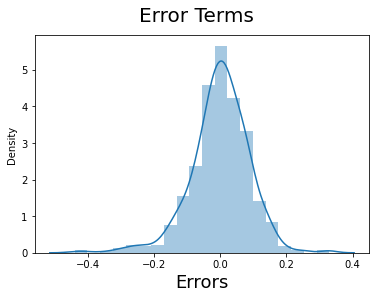

In [1062]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

**Error terms are normally distributed with mean 0, hence, the fit is fine. Plotting residuals**

In [1063]:
res = y_train-y_train_pred

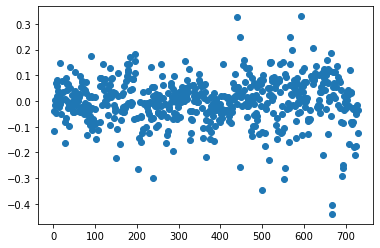

In [1064]:
plt.scatter(X_train_rfe_finetuned.index,res)
plt.show()

**error independence and homoscedasticity confirmed**

## Model Evaluation


In [1065]:
# df_test[col.to_list()] = 
df_test[num_vars] = scaler.transform(df_test[num_vars])
# df_test = df_test[col.to_list()] ## considering only variables required in model
df_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_02,mnth_03,mnth_04,mnth_05,mnth_06,mnth_07,mnth_08,mnth_09,mnth_10,mnth_11,mnth_12,holiday_yes,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_yes,weathersit_cloudy,weathersit_rainy
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
185,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
536,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
300,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
222,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
153,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.879548,0.819364,0.610133,0.322193,0.495168,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
720,0.333364,0.292320,0.573637,0.713904,0.414289,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
4,0.175530,0.174649,0.608434,0.253659,0.177174,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [1066]:
df_test = df_test[col.to_list()+["cnt"]]
df_test

y_test = df_test.pop('cnt')
X_test = df_test

In [1067]:
# Adding a constant variable 
X_test = sm.add_constant(X_test)

y_pred = lm.predict(X_test)

Text(0, 0.5, 'y_pred')

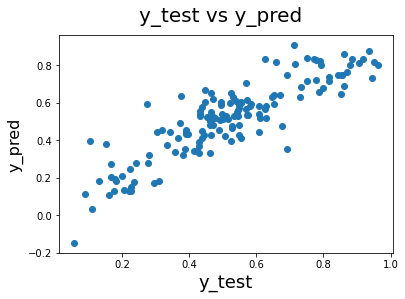

In [1068]:
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)     

In [1069]:
from sklearn.metrics import r2_score
r2_score(y_train,lm.predict(X_train_rfe_finetuned)),r2_score(y_test, y_pred)

(0.8420780196460096, 0.7573996064181627)

Training set and test set r squared are almost similar, hence we can infer our model is a good fit.

## Conclusion
Final equation has following parameters (post scaling params)

In [1070]:
lm.params

const                0.076995
atemp                0.547224
windspeed           -0.135614
season_summer        0.103269
season_winter        0.121118
yr_2019              0.231350
mnth_08              0.066532
mnth_09              0.118463
mnth_10              0.048557
holiday_yes         -0.051910
weekday_6            0.064165
workingday_yes       0.053145
weathersit_cloudy   -0.084799
weathersit_rainy    -0.293664
dtype: float64

In [1071]:
num_vars[[1,3,4]], scaler.data_min_[[1,3,4]] , scaler.data_max_[[1,3,4]]

(Index(['atemp', 'windspeed', 'cnt'], dtype='object'),
 array([ 3.95348  ,  2.8343814, 22.       ]),
 array([  42.0448  ,   34.000021, 8714.      ]))

The variables atemp, windspeed, season, year, month, holiday, weekday, workingday and weather are significant in predicting bike demand.

They predict with test set R-squared ie predictive power of 75%.

**Relatively higher temperature, season of summer and winter, months of August, September and October, working day, Saturdays (weekday_6) drive the demand higher**

**Moreover,high wind speed, holiday and cloudy/rainy weather lead to lower demands**

**Also, demand was higher in 2019 as compared to 2018**